This notebook references the following tutorials:

* generating molecule trajectories with a diffusivity sink
* generating molecule trajectories with a potential energy gradient
* generating molecule trajectories with a transient diffusivity sink
* generating molecule trajectories with a transient potential energy sink

### Note:
The examples below call the low-level API and will be updated so that the higher-level `RWAnalyzer` API is called instead.

# Generating molecule trajectories with a diffusivity sink

Trajectories is a DataFrame with columns *'x'*, *'y'* (spatial coordinates), *'t'* (time) and *'n'* (trajectory index).
Each row is a molecule location.

In [1]:

## key parameters
# number of trajectories
number_of_trajectories = 400
# time step in s
dt = 0.05
# average trajectory lifetime in s
tau = 0.25
# baseline diffusivity in um2.s-1
D0 = 0.1
# diffusivity at the bottom of the sink
D = 0.05
# positionning noise (optional)
sigma = 1e-4

## import
from tramway.helper.simulation import *

## generate the trajectories
trajectories = random_walk_2d(
        n_trajs=number_of_trajectories, N_mean=tau/dt, dt=dt,
        D0=D0, amplitude_D=D0-D, mode_D='gaussian_trap',
        sigma_noise=sigma,
        )

trajectories


/home/flaurent/github/RWA-python/rwa/hdf5.py:185: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel # Panel has been flagged deprecated


,n,x,y,t
0,1,-0.194488,-0.134208,0.50
1,1,-0.073118,0.039709,0.55
2,1,-0.185695,0.131110,0.60
3,1,-0.222388,0.063888,0.65
4,1,-0.397075,0.148815,0.70
...,...,...,...,...
2253,399,-0.490586,-0.300268,292.25
2254,399,-0.486572,-0.295714,292.30
2255,400,0.249949,0.114851,292.80
2256,400,0.441220,0.013106,292.85


#### Note:
`random_walk_2d` does not define a bounding box.

#### See also:

    help(random_walk_2d)

To save the trajectories:
    
    trajectories.to_csv('diffusivity_sink.txt', sep='\t', index=False)

# Generating molecule trajectories with a potential energy gradient

Trajectories is a DataFrame with columns *'x'*, *'y'* (spatial coordinates), *'t'* (time) and *'n'* (trajectory index).
Each row is a molecule location.

In [2]:

## key parameters
# number of trajectories
number_of_trajectories = 400
# time step in s
dt = 0.05
# average trajectory lifetime in s
tau = 0.25
# diffusivity
D = 0.1
# potential energy slope in kB.T
dV = 2
# positionning noise (optional)
sigma = 1e-4

## import
from tramway.helper.simulation import *

## generate the trajectories
trajectories = random_walk_2d(
        n_trajs=number_of_trajectories, N_mean=tau/dt, dt=dt,
        D0=D, amplitude_V=dV, mode_V='potential_linear',
        sigma_noise=sigma,
        )

trajectories


,n,x,y,t
0,1,-0.232928,0.492292,0.50
1,1,-0.243414,0.564468,0.55
2,1,-0.202145,0.397305,0.60
3,2,0.449589,0.321685,1.10
4,2,0.467039,0.306948,1.15
...,...,...,...,...
2353,399,0.330128,0.056196,297.25
2354,399,0.331466,0.161945,297.30
2355,399,0.312937,0.258528,297.35
2356,399,0.198304,0.385117,297.40


#### Note:
`random_walk_2d` does not define a bounding box.

#### See also:

    help(random_walk_2d)

To save the trajectories:
    
    trajectories.to_csv('potential_energy_gradient.txt', sep='\t', index=False)

# Generating molecule trajectories with a transient diffusivity sink

Trajectories is a DataFrame with columns *'x'*, *'y'* (spatial coordinates), *'t'* (time) and *'n'* (trajectory index).
Each row is a molecule location.

In [3]:

## key parameters
# number of trajectories
number_of_trajectories = 500
# time step in s
dt = 0.05
# average trajectory lifetime in s
tau = 0.25
# base diffusivity
D0 = 0.1
# minimum diffusivity
Dmin = 0.05

## import
%matplotlib inline
from tramway.helper import *
from tramway.helper.simulation import *
from math import *
import numpy as np

## define the force function to be evaluated at every location and time

# choose where and when is the minimum potential energy,
# considering default bounding box is the unit hypercube and default duration is 10s
sink_space_center = np.array([.5, .5]) # x, y
sink_time_center = 5. # t
sink_radius = .3
sink_half_duration = 8.

s2r = sink_radius * sink_radius / (-log(.05)) # squared gaussian scale
s2t = sink_half_duration * sink_half_duration / (-log(.05))
def D(r, t):
    r, t = r - sink_space_center, t - sink_time_center
    D_r = exp(-np.dot(r, r) / s2r)
    D_t = exp(-(t * t) / s2t)
    d = D0 - (D0 - Dmin) * D_r * D_t
    assert 0 < d
    return d

## generate the trajectories
trajectories = random_walk(
    diffusivity=D,
    trajectory_mean_count=number_of_trajectories, lifetime_tau=tau, time_step=dt,
    reflect=True,# the trajectories stay inside the box
    # minor_step_count=999,# to achieve similar precision as with random_walk_2d
    )

# crop wrt time
trajectories = trajectories[trajectories['t']<10.] # 10 seconds is the default duration

trajectories


,n,x,y,t
0,1,0.718712,0.357932,0.05
1,1,0.512381,0.326598,0.10
2,1,0.401523,0.351217,0.15
3,1,0.338369,0.306378,0.20
4,1,0.368176,0.328842,0.25
...,...,...,...,...
163431,1248,0.531875,0.989923,9.95
163485,1249,0.883095,0.428212,9.90
163486,1249,0.943415,0.375429,9.95
163702,1250,0.279409,0.614383,9.95


Diffusivity map for all segments:

segment: 0


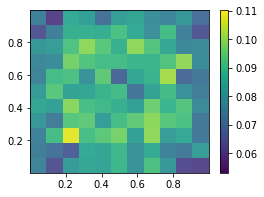

segment: 1


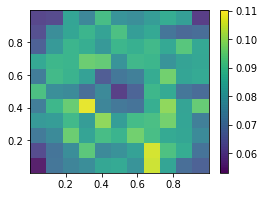

segment: 2


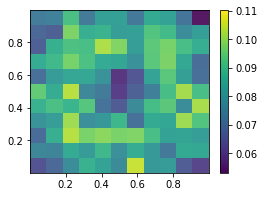

segment: 3


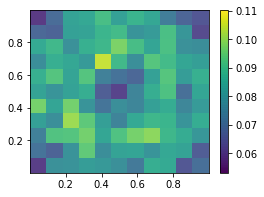

segment: 4


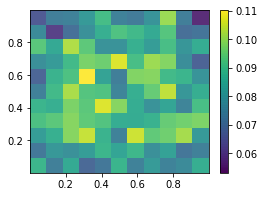

In [4]:

cells = tessellate(trajectories, 'grid', time_window_duration=2.)
maps = infer(cells, 'd', sigma=.01)
number_of_segments = len(cells.tessellation.time_lattice)
for segment in range(number_of_segments):
    print('segment: {}'.format(segment))
    map_plot(maps, cells, segment=segment, show=True, title=False, figsize=(4,3), variable='diffusivity')


If the pattern is not clear enough, increase `number_of_trajectories`.

#### See also:

    help(random_walk)

To save the trajectories:
    
    trajectories.to_csv('transient_diffusivity_sink.txt', sep='\t', index=False)
    

# Generating molecule trajectories with a transient potential energy sink

Trajectories is a DataFrame with columns *'x'*, *'y'* (spatial coordinates), *'t'* (time) and *'n'* (trajectory index).
Each row is a molecule location.

In [5]:

## key parameters
# number of trajectories
number_of_trajectories = 500
# time step in s
dt = 0.05
# average trajectory lifetime in s
tau = 0.25
# diffusivity, in um2.s-1
D = 0.1
# potential energy maximum decrease, in kB.T
delta_V = 3.

## import
%matplotlib inline
from tramway.helper import *
from tramway.helper.simulation import *
from math import *
import numpy as np

## define the force function to be evaluated at every location and time

# choose where and when is the minimum potential energy,
# considering default bounding box is the unit hypercube and default duration is 10s
sink_space_center = np.array([.5, .5]) # x, y
sink_time_center = 5. # t
sink_radius = .2
sink_half_duration = 4.

s2r = sink_radius * sink_radius / (-log(.05)) # squared gaussian scale
s2t = sink_half_duration * sink_half_duration / (-log(.05))
def F(r, t):
    r, t = r - sink_space_center, t - sink_time_center
    grad_V = 2. * r / s2r * exp(-np.dot(r, r) / s2r)
    V_t = exp(-(t * t) / s2t)
    f = delta_V * (-grad_V) * V_t
    return f

## generate the trajectories
trajectories = random_walk(
    diffusivity=D, force=F,
    trajectory_mean_count=number_of_trajectories, lifetime_tau=tau, time_step=dt,
    reflect=True,# the trajectories stay inside the box
    # minor_step_count=999,# to achieve similar precision as with random_walk_2d
    )

# crop wrt time
trajectories = trajectories[trajectories['t']<10.] # 10 seconds is the default duration

trajectories


,n,x,y,t
0,1,0.224052,0.346894,0.05
1,1,0.227266,0.375869,0.10
2,1,0.276869,0.464168,0.15
3,1,0.156301,0.305385,0.20
4,1,0.092283,0.175458,0.25
...,...,...,...,...
161249,1294,0.698215,0.725395,9.90
161250,1294,0.825919,0.805927,9.95
161304,1295,0.966708,0.484536,9.95
161363,1296,0.374215,0.823199,9.95


Force map for all segments:

segment: 0


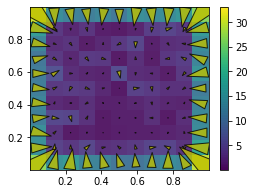

segment: 1


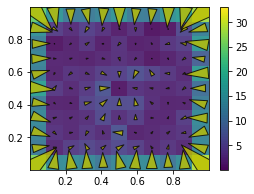

segment: 2


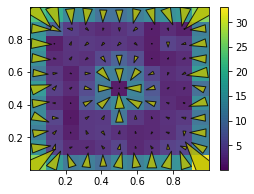

segment: 3


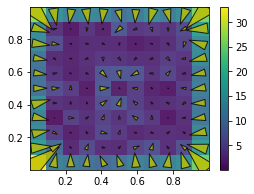

segment: 4


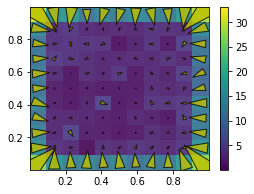

In [6]:

cells = tessellate(trajectories, 'grid', time_window_duration=2.)
maps = infer(cells, 'df', sigma=.01)
number_of_segments = len(cells.tessellation.time_lattice)
for segment in range(number_of_segments):
    print('segment: {}'.format(segment))
    map_plot(maps, cells, segment=segment, show=True, title=False, figsize=(4,3), variable='force')


If the pattern is not clear enough, increase `number_of_trajectories`.

#### See also:

    help(random_walk)

To save the trajectories:
    
    trajectories.to_csv('transient_potential_energy_sink.txt', sep='\t', index=False)
    